In [1]:
import pandas as pd
import numpy as np
import folium
import requests
import matplotlib
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim

matplotlib.style.use('ggplot')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
#Getting the major financial cities in the world from Wikipedia rankings based on the Global Financial Centre Index
df=pd.read_html('https://en.wikipedia.org/wiki/Global_Financial_Centres_Index', skiprows=1, header=0)
df=pd.DataFrame(df[0])
column_list=['Rank', 'Rank Change', 'Centre', 'GFCI Rating', 'Rating Change'] #Sanitizing the column list
df.columns=column_list
df['Rank Change'].replace(to_replace=np.nan, value=0, inplace=True)
df.drop(index=54, inplace=True) # This dropping the duplicated heading that came from the Wikipedia page
df.head()

,Rank,Rank Change,Centre,GFCI Rating,Rating Change
0,1,0,New York City,769,21
1,2,0,London,742,31
2,3,3,Tokyo,741,16
3,4,1,Shanghai,740,21
4,5,1,Singapore,738,24


In [3]:
# Removing 'City' to enable an accurate left join
city_list_org=[]
for i in df['Centre']:
        if 'City' in i:
            if 'Gujarat' in i:
                i=str(i.split(' City')[1])
                city_list_org.append(i)
            else:
                i=str(i.split(' City')[0])
                city_list_org.append(i)
        elif ' (' in i:
            i=str(i.split(' (')[0])
            city_list_org.append(i)
            
        else:
            city_list_org.append(i)

df['Centre']=city_list_org            

In [4]:
#Using Geocode to get coordinate data for the list of cities

lat_list=[]
lng_list=[]
for city in df['Centre']:
    address=city
    geolocator=Nominatim(user_agent='foursquare_agent', timeout=10)
    location=geolocator.geocode(address)
    lat_list.append(location.latitude)
    lng_list.append(location.longitude)
#     print(address) This code is there to check any errors in retrieving data from Nominatim
    
df['Latitude']=lat_list
df['Longitude']=lng_list

df.head()

,Rank,Rank Change,Centre,GFCI Rating,Rating Change,Latitude,Longitude
0,1,0,New York,769,21,40.712728,-74.006015
1,2,0,London,742,31,51.507322,-0.127647
2,3,3,Tokyo,741,16,35.682839,139.759455
3,4,1,Shanghai,740,21,31.225299,121.489050
4,5,1,Singapore,738,24,1.357107,103.819499


In [5]:
### Sample check on the coordinates on the world map

world_map=folium.Map([28.614179, 77.202266], zoom_start=1.5) #Just setting the coords to New Delhi to get a zoom level for the map

for lat, lng, city in zip(df['Latitude'], df['Longitude'], df['Centre']):
    label=f'{city}'
    label=folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat,lng], 
                        radius=5, 
                        popup=label, 
                        color='blue', 
                        fill=True, 
                        fill_color='yellow', 
                        fill_opacity=0.7, parse_html=False).add_to(world_map)
world_map

#### Inserting the country for each city

In [6]:
#Foursquare credentials
CLIENT_ID='VVOCI1PR4IP22KIAOLXUDGIXNSKTDKVJQSKRZX0DQQ52PFVQ'
CLIENT_SECRET='PD4FDWQMU5ZSVMWOIQCKKOPHIVVMKMZGBEL5JGXZ4UBAKTMO'
VERSION='20180605'
Radius=10000 #Some cities does not have enough places, so I have arbitrarily for this purpose set radius to 10000 to get
                #a location just so that I can get the country name
Limit=2 #Just need one venue to identify the corresponding country for the given city


In [7]:
country_list=[]
for lat, lng, centre in zip(df['Latitude'], df['Longitude'], df['Centre']):
    url=f'https://api.foursquare.com/v2/venues/explore?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&ll={lat},{lng}&v={VERSION}&radius={Radius}&limit={Limit}&locale=en'
    result=requests.get(url).json()
    try:
        country=pd.json_normalize(result['response']['groups'][0]['items'])['venue.location.country'][0]
#         print(country, centre) error check code
        country_list.append(country)
    except (KeyError, ValueError):
#         print(centre) error check code
        country_list.append(centre)

df['Country']=country_list
column_list=['Rank', 'Rank Change', 'Centre', 'Country', 'GFCI Rating', 'Rating Change', 'Latitude', 'Longitude']
df=df[column_list]
df.head()

,Rank,Rank Change,Centre,Country,GFCI Rating,Rating Change,Latitude,Longitude
0,1,0,New York,United States,769,21,40.712728,-74.006015
1,2,0,London,United Kingdom,742,31,51.507322,-0.127647
2,3,3,Tokyo,Japan,741,16,35.682839,139.759455
3,4,1,Shanghai,China,740,21,31.225299,121.489050
4,5,1,Singapore,Singapore,738,24,1.357107,103.819499


In [8]:
#First source of data for cities GDP per capita (PPP)

cities_df=pd.read_html('https://en.wikipedia.org/wiki/List_of_cities_by_GDP_(PPP)_per_capita') #Wikipedia source
cities_df=pd.DataFrame(cities_df[0])
cities_df.columns=['MET_ID', 'City', 'GDP Per Capita']
cities_df.head()

,MET_ID,City,GDP Per Capita
0,USA05,San Francisco (Greater),94699
1,LU001,Luxembourg,88312
2,USA14,Seattle,78262
3,USA11,Boston,78183
4,USA01,New York (Greater),74244


In [9]:
#Removing the unnecessary components in the City column to allow joins

city_list=[]
for i in cities_df['City']:
    if '(' in i:
        i=i.split(' (')[0]
#         print(i)
        city_list.append(i)
    else:
#         print(i)
        city_list.append(i)

cities_df['City']=city_list
cities_df.drop_duplicates('City', inplace=True)
cities_df.head()

,MET_ID,City,GDP Per Capita
0,USA05,San Francisco,94699
1,LU001,Luxembourg,88312
2,USA14,Seattle,78262
3,USA11,Boston,78183
4,USA01,New York,74244


In [10]:
econ_df=df.copy()
econ_df=econ_df.merge(cities_df[['City','GDP Per Capita']], how='left', left_on='Centre', right_on='City', )
econ_df.head()

,Rank,Rank Change,Centre,Country,GFCI Rating,Rating Change,Latitude,Longitude,City,GDP Per Capita
0,1,0,New York,United States,769,21,40.712728,-74.006015,New York,74244.0
1,2,0,London,United Kingdom,742,31,51.507322,-0.127647,London,58827.0
2,3,3,Tokyo,Japan,741,16,35.682839,139.759455,NaN,NaN
3,4,1,Shanghai,China,740,21,31.225299,121.489050,NaN,NaN
4,5,1,Singapore,Singapore,738,24,1.357107,103.819499,NaN,NaN


In [11]:
#Second source of data for cities GDP per capita (PPP) 

cities_df1=pd.read_csv('http://www.worldcitiescultureforum.com/assets/city_data/Average_income_per_capita_per_year_%28ppp%29_5112018.csv')
remove_list=['Notes', 'Per capita']
cities_df1.drop(columns=remove_list, inplace=True)

#Removing the $sign in the 'Figure' columns
cities_df1['Figure']=cities_df1['Figure'].str.replace('$', '')
cities_df1['Figure']=cities_df1['Figure'].str.replace(',', '')
cities_df1['Figure']=cities_df1['Figure'].astype('float')
cities_df1.columns=['City1', 'Per Capita', 'Year', 'Source']
cities_df1.head()

,City1,Per Capita,Year,Source
0,Amsterdam,19271.0,2012,Statistics Netherlands/TNO
1,Netherlands,17492.0,2009,Statistics Netherlands /RIO
2,Austin,39103.0,2016,Census Reporter
3,United States,28155.0,2013,US Census Bureau
4,Bogotá,9004.0,2014,Observatorio de Desarrollo Económico de Bogotá...


In [12]:
econ_df=econ_df.merge(cities_df1[['City1', 'Per Capita']], how='left', left_on='Centre', right_on='City1')
econ_df.head()
                                  

,Rank,Rank Change,Centre,Country,GFCI Rating,Rating Change,Latitude,Longitude,City,GDP Per Capita,City1,Per Capita
0,1,0,New York,United States,769,21,40.712728,-74.006015,New York,74244.0,New York,34099.0
1,2,0,London,United Kingdom,742,31,51.507322,-0.127647,London,58827.0,London,38537.0
2,3,3,Tokyo,Japan,741,16,35.682839,139.759455,NaN,NaN,Tokyo,60678.0
3,4,1,Shanghai,China,740,21,31.225299,121.489050,NaN,NaN,Shanghai,22473.0
4,5,1,Singapore,Singapore,738,24,1.357107,103.819499,NaN,NaN,Singapore,54224.0


In [13]:
#Filling in the NaN figures in the original GDP per Capita column with the data from the cities_df1 join

gdp_data=[]
for first, second in zip(econ_df['GDP Per Capita'], econ_df['Per Capita']):
    if np.isnan(first):
        gdp_data.append(second)
    else:
        gdp_data.append(first)

econ_df['GDP Per Capita']=gdp_data
econ_df.head()

,Rank,Rank Change,Centre,Country,GFCI Rating,Rating Change,Latitude,Longitude,City,GDP Per Capita,City1,Per Capita
0,1,0,New York,United States,769,21,40.712728,-74.006015,New York,74244.0,New York,34099.0
1,2,0,London,United Kingdom,742,31,51.507322,-0.127647,London,58827.0,London,38537.0
2,3,3,Tokyo,Japan,741,16,35.682839,139.759455,NaN,60678.0,Tokyo,60678.0
3,4,1,Shanghai,China,740,21,31.225299,121.489050,NaN,22473.0,Shanghai,22473.0
4,5,1,Singapore,Singapore,738,24,1.357107,103.819499,NaN,54224.0,Singapore,54224.0


In [14]:
nulls=econ_df['GDP Per Capita'].isnull().sum()
print(f'The count of cities with no GDP per capita data: {nulls}')

The count of cities with no GDP per capita data: 55


In [15]:
#The above nulls will be filled with corresponding country GDP per capitas obtained from the world bank
cities_df2=pd.read_csv('GDPpercapitaWB.csv', encoding='latin1', sep='\t')

#Any nan figures in 2018 will be replace with the latest figure available over the last three years
nan_replace=[]
for first, second, third in zip(cities_df2['2016'], cities_df2['2017'], cities_df2['2018']):
    if np.isnan(third):
        if np.isnan(second):
            nan_replace.append(first)
        else:
            nan_replace.append(second)
    else:
        nan_replace.append(third)
cities_df2['Latest GDPpercapita']=nan_replace

remove_list=['Indicator Name', '2016', '2017', '2018']
cities_df2.drop(columns=remove_list, inplace=True)
cities_df2['Latest GDPpercapita']=cities_df2['Latest GDPpercapita'].apply(lambda x: round(x, 1))
cities_df2['Country Name'].replace('Korea, Rep.', 'South Korea', inplace=True)
cities_df2.head()

,Country Name,Country Code,Latest GDPpercapita
0,Aruba,ABW,33966.5
1,Afghanistan,AFG,2172.8
2,Angola,AGO,6924.3
3,Albania,ALB,13670.1
4,Andorra,AND,NaN


In [16]:
#Merging with the econ_df on country basis
econ_df=econ_df.merge(cities_df2[['Country Name', 'Latest GDPpercapita']], how='left', left_on='Country', right_on='Country Name')
remove_list=['Country Name', 'City', 'City1', 'Per Capita']
try:
    econ_df.drop(columns=remove_list, inplace=True)
except:
    pass
econ_df.head()

,Rank,Rank Change,Centre,Country,GFCI Rating,Rating Change,Latitude,Longitude,GDP Per Capita,Latest GDPpercapita
0,1,0,New York,United States,769,21,40.712728,-74.006015,74244.0,61391.4
1,2,0,London,United Kingdom,742,31,51.507322,-0.127647,58827.0,46330.3
2,3,3,Tokyo,Japan,741,16,35.682839,139.759455,60678.0,41206.0
3,4,1,Shanghai,China,740,21,31.225299,121.489050,22473.0,15010.6
4,5,1,Singapore,Singapore,738,24,1.357107,103.819499,54224.0,96477.2


In [17]:
#replacing the nan figures in the GDP Per Capita column

gdp_data=[]
for first, second in zip(econ_df['GDP Per Capita'], econ_df['Latest GDPpercapita']):
    if np.isnan(first) or first<second:
        gdp_data.append(second)
        
    else:
        gdp_data.append(first)

econ_df['GDP Per Capita']=gdp_data

#Dropping all rows with na values

print('Total number of rows that will be dropped = {}'.format(econ_df['GDP Per Capita'].isnull().sum()))
econ_df.drop(columns='Latest GDPpercapita', inplace=True)
econ_df.dropna(axis=0, inplace=True)
econ_df.reset_index(drop=True)
econ_df.head()

Total number of rows that will be dropped = 12


,Rank,Rank Change,Centre,Country,GFCI Rating,Rating Change,Latitude,Longitude,GDP Per Capita
0,1,0,New York,United States,769,21,40.712728,-74.006015,74244.0
1,2,0,London,United Kingdom,742,31,51.507322,-0.127647,58827.0
2,3,3,Tokyo,Japan,741,16,35.682839,139.759455,60678.0
3,4,1,Shanghai,China,740,21,31.225299,121.489050,22473.0
4,5,1,Singapore,Singapore,738,24,1.357107,103.819499,96477.2


In [18]:
#Inserting world bank data in one go
econ_df1=econ_df.copy()
data_list=['Account ownership % of population', 
           'Business extent of disclosure index', 
           'Ease of doing business index', 
           'Government effectiveness estimate', 
           'Logistics performance index_QOT', 
           'Market capitalization % of GDP', 
           'Rule of law estimate']

data_loc='C:/Users/Manula/Desktop/Python/Coursera/Project Capstone/Final Project Capstone/Data/World Bank data'
for i, data in enumerate(data_list):
    temp_df=pd.read_excel(f'{data_loc}/{data}.xlsx', skipfooter=1)
    temp_df.replace('..', np.nan, inplace=True)
    temp_df.dropna(axis=1, how='all', inplace=True)
    temp_df.columns=['Country Name']+temp_df.columns.values.tolist()[1:]
    
    latest_year=temp_df.columns.values.tolist() #Getting the latest year from the list of columns
    latest_year.sort(reverse=True)
    latest_year=latest_year[1]
    
    econ_df1=econ_df1.merge(temp_df[['Country Name', latest_year]], how='left', left_on='Country', 
                 right_on='Country Name')
    econ_df1[data]=econ_df1[latest_year]
    econ_df1.drop(columns=['Country Name', latest_year], inplace=True)
    print(data)

#Joining UNDP data of gender inequality separately

data_list=data_list+['Gender Inequality Index']
temp_df=pd.read_excel(f'{data_loc}/Gender inequality index.xlsx')
temp_df.replace('..', np.nan, inplace=True)
temp_df['Gender Inequality Index']=temp_df['Gender Inequality Index'].apply(lambda x: round(x,1))
econ_df1=econ_df1.merge(temp_df[['Country Name', 'Gender Inequality Index']], how='left', left_on='Country', right_on='Country Name')
econ_df1.drop(columns=['Country Name'], inplace=True)    

#Replacing all NaN values with median values of the respective column

print(f'Total null figures filled with median: {econ_df1.isnull().sum()}')
for col in data_list:
    econ_df1[col].replace(np.nan, econ_df1[col].agg('median'), inplace=True)

econ_df1.head()


Account ownership % of population
Business extent of disclosure index
Ease of doing business index
Government effectiveness estimate
Logistics performance index_QOT
Market capitalization % of GDP
Rule of law estimate
Total null figures filled with median: Rank                                    0
Rank Change                             0
Centre                                  0
Country                                 0
GFCI Rating                             0
Rating Change                           0
Latitude                                0
Longitude                               0
GDP Per Capita                          0
Account ownership % of population       8
Business extent of disclosure index     5
Ease of doing business index            5
Government effectiveness estimate       4
Logistics performance index_QOT         7
Market capitalization % of GDP         23
Rule of law estimate                    4
Gender Inequality Index                 6
dtype: int64


,Rank,Rank Change,Centre,Country,GFCI Rating,Rating Change,Latitude,Longitude,GDP Per Capita,Account ownership % of population,Business extent of disclosure index,Ease of doing business index,Government effectiveness estimate,Logistics performance index_QOT,Market capitalization % of GDP,Rule of law estimate,Gender Inequality Index
0,1,0,New York,United States,769,21,40.712728,-74.006015,74244.0,93.1,7.4,84.0,1.6,4.1,148.1,1.5,0.2
1,2,0,London,United Kingdom,742,31,51.507322,-0.127647,58827.0,96.4,10.0,83.5,1.3,4.0,56.95,1.6,0.1
2,3,3,Tokyo,Japan,741,16,35.682839,139.759455,60678.0,98.2,7.0,78.0,1.7,4.3,106.5,1.5,0.1
3,4,1,Shanghai,China,740,21,31.225299,121.489050,22473.0,80.2,10.0,77.9,0.5,3.8,46.5,-0.2,0.2
4,5,1,Singapore,Singapore,738,24,1.357107,103.819499,96477.2,97.9,10.0,86.2,2.2,4.1,188.7,1.8,0.1


### The following part will be on getting the 10 most common venues in each city within a radius of 10km of the centre, this essentially will be able to show us the ease of having most important business institutions within close proximity

In [19]:
Radius=10000
Limit=1000
lat=19.541721
lng=-80.566713
url=f'https://api.foursquare.com/v2/venues/explore?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&ll={lat},{lng}&v={VERSION}&radius={Radius}&limit={Limit}&locale=en'

In [20]:
Radius=10000
Limit=1000

city_list=[]

#Declaring empty lists of most common venues
lists_dict={}
for i in range(10):
    lists_dict[f'most_common_venue{i+1}']=[]



for city, lat, lng in zip(econ_df1['Centre'], econ_df1['Latitude'], econ_df1['Longitude']):
    city_list.append(city)
    try:
        url=f'https://api.foursquare.com/v2/venues/search?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&ll={lat},{lng}&v={VERSION}&radius={Radius}&limit={Limit}&locale=en'
        results=requests.get(url).json()
        temp_df=pd.json_normalize(results['response']['venues'])
        #Refining the JSON dataframe
        column_list=['name', 'categories', 'location.lat', 'location.lng']
        category_list=[]
        for name, i in zip(temp_df['name'],temp_df['categories']):
            try:
                x=i[0]['name']
                category_list.append(x)
            except IndexError:
                category_list.append(name)

        temp_df['categories']=category_list
        temp_df=temp_df[column_list]

        #Getting the frequency of the places in each city
        freq_df=pd.DataFrame(temp_df['categories'].value_counts().reset_index())
        for i in range(10):
            try:
                lists_dict[f'most_common_venue{i+1}'].append(freq_df['index'][i])
            except KeyError:
                lists_dict[f'most_common_venue{i+1}'].append(np.nan)
        
        print(city, end=' ') #Error checking
    
    except (ValueError, KeyError): #Any city that does not have data will populate NaN 
        for i in range(10):
            lists_dict[f'most_common_venue{i+1}'].append(np.nan)
        print(f'Error city: {city}')
        
            
        

venue_df=pd.DataFrame(lists_dict)
venue_df.insert(0, 'City', city_list)
venue_df.head()

New York London Tokyo Shanghai Singapore Hong Kong Beijing San Francisco Geneva Los Angeles Shenzhen Dubai Frankfurt Zurich Paris Chicago Edinburgh Luxembourg Guangzhou Sydney Melbourne Vancouver Toronto Washington, D.C. Boston Montreal Amsterdam Stockholm Hamburg Dublin Wellington Stuttgart Seoul Brussels Copenhagen Tel Aviv Munich Vienna Abu Dhabi Calgary Casablanca Milan Madrid Kuala Lumpur Mumbai Prague Error city: Cayman Islands
Doha Warsaw Busan Tallinn Rome Almaty Bahrain Baku Bangkok Osaka Oslo Mauritius Glasgow Vilnius Cyprus Helsinki New Delhi Riga Moscow Nur-Sultan Chengdu Mexico Istanbul Cape Town San Diego -Gujarat São Paulo Budapest Johannesburg Monaco Nairobi Riyadh Rio de Janeiro Kuwait Reykjavik Jakarta Panama Athens Hangzhou Qingdao Tianjin Nanjing Dalian Manila Santiago Buenos Aires Malta Barbados 

,City,most_common_venue1,most_common_venue2,most_common_venue3,most_common_venue4,most_common_venue5,most_common_venue6,most_common_venue7,most_common_venue8,most_common_venue9,most_common_venue10
0,New York,Office,College Classroom,Food Truck,Government Building,Bus Station,Lawyer,Building,Mexican Restaurant,Plaza,General College & University
1,London,Office,Outdoor Sculpture,Coworking Space,Building,Sandwich Place,Restaurant,Government Building,Coffee Shop,Bus Stop,Gift Shop
2,Tokyo,Historic Site,Office,Japanese Restaurant,Convenience Store,Chinese Restaurant,Government Building,Hotel Bar,Police Station,Italian Restaurant,Lounge
3,Shanghai,Chinese Restaurant,Clothing Store,Shanghai Restaurant,Asian Restaurant,Noodle House,Tea Room,Ice Cream Shop,Salon / Barbershop,Jewelry Store,Dessert Shop
4,Singapore,Trail,Office,Event Space,Café,Golf Course,Rest Area,Parking,Medical Center,Gym,Coworking Space


In [21]:
#Manually mapping to dummy variables

unique_list=[]
for i in lists_dict:
    unique_list.append(np.unique(lists_dict[i]).tolist())

unique_list=[x for i in unique_list for x in i]
unique_list=np.unique(unique_list).tolist()

map_dict={}
for i, cat in enumerate(unique_list):
    map_dict[cat]=i
    

venue_df1=venue_df.copy()
for col in list(lists_dict.keys()):
    venue_df1[col]=venue_df1[col].map(map_dict)

venue_df1.head()

,City,most_common_venue1,most_common_venue2,most_common_venue3,most_common_venue4,most_common_venue5,most_common_venue6,most_common_venue7,most_common_venue8,most_common_venue9,most_common_venue10
0,New York,156.0,53.0,88.0,102.0,31.0,132.0,28.0,141.0,168.0,97.0
1,London,156.0,160.0,65.0,28.0,180.0,178.0,102.0,48.0,32.0,100.0
2,Tokyo,111.0,156.0,124.0,61.0,42.0,102.0,116.0,169.0,123.0,134.0
3,Shanghai,42.0,46.0,188.0,10.0,155.0,202.0,120.0,179.0,125.0,73.0
4,Singapore,212.0,156.0,81.0,34.0,101.0,177.0,162.0,137.0,105.0,65.0


#### Standardizing the feature dataset

In [22]:
#Importing the necessary packages from sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [23]:
#Standardizing/Scaling down the mapped numbers of the venue_df1 dataframe
print(len(unique_list))
tobe_scaled=[x for x in range(len(unique_list))]
mean_x=np.mean(tobe_scaled)
std_x=np.std(tobe_scaled)
map_dict1={}
for i in tobe_scaled:
    map_dict1[i]=(i-mean_x)/std_x

venue_df2=venue_df1.copy()

for col in list(lists_dict.keys()):
    venue_df2[col]=venue_df1[col].map(map_dict1)

venue_df2.head()

222


,City,most_common_venue1,most_common_venue2,most_common_venue3,most_common_venue4,most_common_venue5,most_common_venue6,most_common_venue7,most_common_venue8,most_common_venue9,most_common_venue10
0,New York,0.709992,-0.897243,-0.351095,-0.132636,-1.240535,0.335491,-1.287348,0.475929,0.897243,-0.210657
1,London,0.709992,0.772409,-0.709992,-1.287348,1.084493,1.053285,-0.132636,-0.975264,-1.224931,-0.163844
2,Tokyo,0.007802,0.709992,0.210657,-0.772409,-1.068889,-0.132636,0.085823,0.912847,0.195053,0.366699
3,Shanghai,-1.068889,-1.006472,1.209327,-1.568224,0.694388,1.427786,0.148240,1.068889,0.226261,-0.585158
4,Singapore,1.583828,0.709992,-0.460324,-1.193723,-0.148240,1.037681,0.803617,0.413512,-0.085823,-0.709992


In [24]:
#I will be scaling only the varibles in the econ_df1 dataframe
column_list=['GFCI Rating', 'GDP Per Capita',
       'Account ownership % of population',
       'Business extent of disclosure index', 'Ease of doing business index',
       'Government effectiveness estimate', 'Logistics performance index_QOT',
       'Market capitalization % of GDP', 'Rule of law estimate',
       'Gender Inequality Index']


feature1=econ_df1[column_list]
scale=StandardScaler()
feature1_scaled=scale.fit_transform(feature1)

In [25]:
feature_df=pd.DataFrame(feature1_scaled, columns=column_list)
feature_df.insert(0, 'Centre', city_list)
feature_df=feature_df.merge(venue_df2, how='left', left_on='Centre', right_on='City')
feature_df.drop(columns='City', inplace=True)
feature_df=feature_df.merge(econ_df1[['Centre', 'Latitude', 'Longitude']], how='left', left_on='Centre', right_on='Centre')

#Resetting the order of the columns
column_list=['Centre','Latitude', 'Longitude', 'GFCI Rating', 'GDP Per Capita',
       'Account ownership % of population',
       'Business extent of disclosure index', 'Ease of doing business index',
       'Government effectiveness estimate', 'Logistics performance index_QOT',
       'Market capitalization % of GDP', 'Rule of law estimate',
       'Gender Inequality Index', 'most_common_venue1', 'most_common_venue2',
       'most_common_venue3', 'most_common_venue4', 'most_common_venue5',
       'most_common_venue6', 'most_common_venue7', 'most_common_venue8',
       'most_common_venue9', 'most_common_venue10']

feature_df=feature_df[column_list]
#Since there is only a very small number of NaN figures in the dataframe I will fill these with 0
feature_df.fillna(0, axis=0, inplace=True)
feature_df.head()

,Centre,Latitude,Longitude,GFCI Rating,GDP Per Capita,Account ownership % of population,Business extent of disclosure index,Ease of doing business index,Government effectiveness estimate,Logistics performance index_QOT,Market capitalization % of GDP,Rule of law estimate,Gender Inequality Index,most_common_venue1,most_common_venue2,most_common_venue3,most_common_venue4,most_common_venue5,most_common_venue6,most_common_venue7,most_common_venue8,most_common_venue9,most_common_venue10
0,New York,40.712728,-74.006015,2.306475,1.374000,0.471424,-0.026300,1.192666,0.944053,0.969602,1.623658,0.853200,0.039968,0.709992,-0.897243,-0.351095,-0.132636,-1.240535,0.335491,-1.287348,0.475929,0.897243,-0.210657
1,London,51.507322,-0.127647,1.679038,0.723033,0.670819,1.093735,1.111965,0.507275,0.782001,-0.327569,0.974357,-0.719425,0.709992,0.772409,-0.709992,-1.287348,1.084493,1.053285,-0.132636,-0.975264,-1.224931,-0.163844
2,Tokyo,35.682839,139.759455,1.655799,0.801190,0.779580,-0.198613,0.224262,1.089645,1.344805,0.733137,0.853200,-0.719425,0.007802,0.709992,0.210657,-0.772409,-1.068889,-0.132636,0.085823,0.912847,0.195053,0.366699
3,Shanghai,31.225299,121.489050,1.632561,-0.811976,-0.308029,1.093735,0.208122,-0.657465,0.406799,-0.551269,-1.206468,0.039968,-1.068889,-1.006472,1.209327,-1.568224,0.694388,1.427786,0.148240,1.068889,0.226261,-0.585158
4,Singapore,1.357107,103.819499,1.586084,2.312773,0.761453,1.093735,1.547747,1.817608,0.969602,2.492773,1.216670,-0.719425,1.583828,0.709992,-0.460324,-1.193723,-0.148240,1.037681,0.803617,0.413512,-0.085823,-0.709992


#### Initiating Kmeans Clustering

In [26]:
# From the elbow method carried below 2-3 clusters seems appropriate, I will pick 3
Kclusters=3
X=feature_df.iloc[:, 3:]
model=KMeans(n_clusters=Kclusters, random_state=42)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

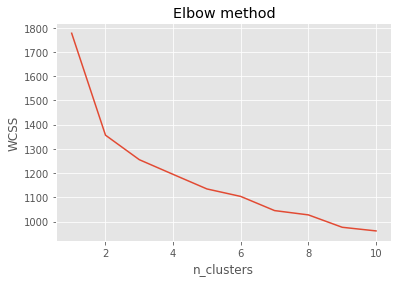

In [27]:
#Identifying the ideal n_clusters using the elbow method

WCSS=[]
for i in range(10):
    model_error=KMeans(n_clusters=i+1)
    model_error.fit(X)
    error=model_error.inertia_
    WCSS.append(error)
    
plt.plot(list(range(1,11)), WCSS)
plt.title('Elbow method')
plt.xlabel('n_clusters')
plt.ylabel('WCSS')
plt.show()

In [28]:
#Inserting the cluster labels
feature_df.insert(1, 'Cluster Labels', model.labels_)
feature_df.head(10)

,Centre,Cluster Labels,Latitude,Longitude,GFCI Rating,GDP Per Capita,Account ownership % of population,Business extent of disclosure index,Ease of doing business index,Government effectiveness estimate,Logistics performance index_QOT,Market capitalization % of GDP,Rule of law estimate,Gender Inequality Index,most_common_venue1,most_common_venue2,most_common_venue3,most_common_venue4,most_common_venue5,most_common_venue6,most_common_venue7,most_common_venue8,most_common_venue9,most_common_venue10
0,New York,1,40.712728,-74.006015,2.306475,1.374000,0.471424,-0.026300,1.192666,0.944053,0.969602,1.623658,0.853200,0.039968,0.709992,-0.897243,-0.351095,-0.132636,-1.240535,0.335491,-1.287348,0.475929,0.897243,-0.210657
1,London,1,51.507322,-0.127647,1.679038,0.723033,0.670819,1.093735,1.111965,0.507275,0.782001,-0.327569,0.974357,-0.719425,0.709992,0.772409,-0.709992,-1.287348,1.084493,1.053285,-0.132636,-0.975264,-1.224931,-0.163844
2,Tokyo,1,35.682839,139.759455,1.655799,0.801190,0.779580,-0.198613,0.224262,1.089645,1.344805,0.733137,0.853200,-0.719425,0.007802,0.709992,0.210657,-0.772409,-1.068889,-0.132636,0.085823,0.912847,0.195053,0.366699
3,Shanghai,2,31.225299,121.489050,1.632561,-0.811976,-0.308029,1.093735,0.208122,-0.657465,0.406799,-0.551269,-1.206468,0.039968,-1.068889,-1.006472,1.209327,-1.568224,0.694388,1.427786,0.148240,1.068889,0.226261,-0.585158
4,Singapore,1,1.357107,103.819499,1.586084,2.312773,0.761453,1.093735,1.547747,1.817608,0.969602,2.492773,1.216670,-0.719425,1.583828,0.709992,-0.460324,-1.193723,-0.148240,1.037681,0.803617,0.413512,-0.085823,-0.709992
5,Hong Kong,1,22.279328,114.162813,1.562845,-0.342108,0.453297,0.232169,0.208122,0.070497,0.406799,-0.327569,0.005101,0.039968,0.709992,-1.287348,-0.553950,-1.224931,-0.491533,-1.458995,-1.256140,-0.132636,-0.413512,-0.741200
6,Beijing,2,39.906217,116.391276,1.493130,-1.127068,-0.308029,1.093735,0.208122,-0.657465,0.406799,-0.551269,-1.206468,0.039968,0.007802,0.070219,-0.413512,-1.068889,-1.568224,1.053285,0.553950,0.460324,0.897243,0.788013
7,San Francisco,1,37.779026,-122.419906,1.446653,2.237691,0.471424,-0.026300,1.192666,0.944053,0.969602,1.623658,0.853200,0.039968,-1.022076,-1.256140,-0.132636,-1.615037,-0.803617,0.819222,-0.351095,1.490203,0.413512,0.663179
8,Geneva,1,46.201756,6.146601,1.376938,1.130972,0.791665,-3.214092,-0.001699,1.526423,0.782001,2.828859,1.337827,-1.478817,-0.132636,0.195053,-1.443390,1.380973,0.709992,0.007802,-1.615037,-0.304282,-1.599433,-1.037681
9,Los Angeles,1,34.053691,-118.242767,1.237507,0.831312,0.471424,-0.026300,1.192666,0.944053,0.969602,1.623658,0.853200,0.039968,-1.022076,-0.132636,-0.725596,-0.351095,0.600762,-0.195053,0.709992,0.803617,-1.256140,-1.505807


#### Naming the clusters : From the analysis it could be identified that the financial cities can be classied into three main clusters as the Top-tier cities, Mid-tier cities & Lower-tier cities

In [29]:
#After running the analysis once the cluster names can be identified when looking at the results of the feature_df.head():
#The cluster that has New York and London is: Top Tier
#The cluster that has Beijing, Shenzen and Milan is: Mid Tier
#The cluster that has Gujarat & New Delhi is: Lower Tier

#I'm running a while loop to confirm the cluster labels again
confirm='no'
while confirm=='no':
    cluster0=input('Enter name of the cluster0, Choose from Top Tier, Mid Tier or Lower Tier: ')
    cluster1=input('Enter name of the cluster1, Choose from Top Tier, Mid Tier or Lower Tier: ')
    cluster2=input('Enter name of the cluster2, Choose from Top Tier, Mid Tier or Lower Tier: ')
    
    print('\n')
    print('The clusters are named as follows: ')
    print(f'Cluster 0={cluster0}, Cluster 1={cluster1}, Cluster 2={cluster2}')
    confirm=input('Please confirm the above labels, Enter yes/no:')
    confirm=confirm.lower()

named_cluster_list=[cluster0.title(), cluster1.title(), cluster2.title()]

color_dict={'Top Tier': 'green', 'Mid Tier': 'blue', 'Lower Tier': 'red'}
radius_dict={'Top Tier': 12, 'Mid Tier': 7, 'Lower Tier': 4}

Enter name of the cluster0, Choose from Top Tier, Mid Tier or Lower Tier: Lower Tier
Enter name of the cluster1, Choose from Top Tier, Mid Tier or Lower Tier: Top Tier
Enter name of the cluster2, Choose from Top Tier, Mid Tier or Lower Tier: Mid Tier


The clusters are named as follows: 
Cluster 0=Lower Tier, Cluster 1=Top Tier, Cluster 2=Mid Tier
Please confirm the above labels, Enter yes/no:yes


In [30]:
#Creating a new refined Dataframe before naming the clusters

fincity_df=econ_df1.merge(venue_df, how='left', left_on='Centre', right_on='City')
fincity_df.drop(columns='City', inplace=True)
fincity_df=fincity_df.merge(feature_df[['Centre', 'Cluster Labels']], how='left', left_on='Centre', right_on='Centre')

#Mapping clusters to the identified names

cluster_names_dict={}
for i in range(Kclusters):
    cluster_names_dict[i]=named_cluster_list[i]

fincity_df['Cluster Names']=fincity_df['Cluster Labels'].map(cluster_names_dict)

#Generating the colors and the radius list to be used in mapping
radius_list=[]
colors_list=[]
for i in range(Kclusters):
    colors_list.append(color_dict[cluster_names_dict[i]])
    radius_list.append(radius_dict[cluster_names_dict[i]])



#Rearranging the columns
column_list=['Rank', 'Rank Change', 'Centre', 'Country','Cluster Names', 'Cluster Labels', 'GFCI Rating',
       'Rating Change', 'Latitude', 'Longitude', 'GDP Per Capita',
       'Account ownership % of population',
       'Business extent of disclosure index', 'Ease of doing business index',
       'Government effectiveness estimate', 'Logistics performance index_QOT',
       'Market capitalization % of GDP', 'Rule of law estimate',
       'Gender Inequality Index', 'most_common_venue1', 'most_common_venue2',
       'most_common_venue3', 'most_common_venue4', 'most_common_venue5',
       'most_common_venue6', 'most_common_venue7', 'most_common_venue8',
       'most_common_venue9', 'most_common_venue10']

fincity_df=fincity_df[column_list]
fincity_df.head()

,Rank,Rank Change,Centre,Country,Cluster Names,Cluster Labels,GFCI Rating,Rating Change,Latitude,Longitude,GDP Per Capita,Account ownership % of population,Business extent of disclosure index,Ease of doing business index,Government effectiveness estimate,Logistics performance index_QOT,Market capitalization % of GDP,Rule of law estimate,Gender Inequality Index,most_common_venue1,most_common_venue2,most_common_venue3,most_common_venue4,most_common_venue5,most_common_venue6,most_common_venue7,most_common_venue8,most_common_venue9,most_common_venue10
0,1,0,New York,United States,Top Tier,1,769,21,40.712728,-74.006015,74244.0,93.1,7.4,84.0,1.6,4.1,148.1,1.5,0.2,Office,College Classroom,Food Truck,Government Building,Bus Station,Lawyer,Building,Mexican Restaurant,Plaza,General College & University
1,2,0,London,United Kingdom,Top Tier,1,742,31,51.507322,-0.127647,58827.0,96.4,10.0,83.5,1.3,4.0,56.95,1.6,0.1,Office,Outdoor Sculpture,Coworking Space,Building,Sandwich Place,Restaurant,Government Building,Coffee Shop,Bus Stop,Gift Shop
2,3,3,Tokyo,Japan,Top Tier,1,741,16,35.682839,139.759455,60678.0,98.2,7.0,78.0,1.7,4.3,106.5,1.5,0.1,Historic Site,Office,Japanese Restaurant,Convenience Store,Chinese Restaurant,Government Building,Hotel Bar,Police Station,Italian Restaurant,Lounge
3,4,1,Shanghai,China,Mid Tier,2,740,21,31.225299,121.489050,22473.0,80.2,10.0,77.9,0.5,3.8,46.5,-0.2,0.2,Chinese Restaurant,Clothing Store,Shanghai Restaurant,Asian Restaurant,Noodle House,Tea Room,Ice Cream Shop,Salon / Barbershop,Jewelry Store,Dessert Shop
4,5,1,Singapore,Singapore,Top Tier,1,738,24,1.357107,103.819499,96477.2,97.9,10.0,86.2,2.2,4.1,188.7,1.8,0.1,Trail,Office,Event Space,Café,Golf Course,Rest Area,Parking,Medical Center,Gym,Coworking Space


##### Cluster : Top tier 

In [31]:
fincity_df[fincity_df['Cluster Names']=='Top Tier'].head(10)

,Rank,Rank Change,Centre,Country,Cluster Names,Cluster Labels,GFCI Rating,Rating Change,Latitude,Longitude,GDP Per Capita,Account ownership % of population,Business extent of disclosure index,Ease of doing business index,Government effectiveness estimate,Logistics performance index_QOT,Market capitalization % of GDP,Rule of law estimate,Gender Inequality Index,most_common_venue1,most_common_venue2,most_common_venue3,most_common_venue4,most_common_venue5,most_common_venue6,most_common_venue7,most_common_venue8,most_common_venue9,most_common_venue10
0,1,0,New York,United States,Top Tier,1,769,21,40.712728,-74.006015,74244.0,93.1,7.4,84.0,1.6,4.1,148.1,1.5,0.2,Office,College Classroom,Food Truck,Government Building,Bus Station,Lawyer,Building,Mexican Restaurant,Plaza,General College & University
1,2,0,London,United Kingdom,Top Tier,1,742,31,51.507322,-0.127647,58827.0,96.4,10.0,83.5,1.3,4.0,56.95,1.6,0.1,Office,Outdoor Sculpture,Coworking Space,Building,Sandwich Place,Restaurant,Government Building,Coffee Shop,Bus Stop,Gift Shop
2,3,3,Tokyo,Japan,Top Tier,1,741,16,35.682839,139.759455,60678.0,98.2,7.0,78.0,1.7,4.3,106.5,1.5,0.1,Historic Site,Office,Japanese Restaurant,Convenience Store,Chinese Restaurant,Government Building,Hotel Bar,Police Station,Italian Restaurant,Lounge
4,5,1,Singapore,Singapore,Top Tier,1,738,24,1.357107,103.819499,96477.2,97.9,10.0,86.2,2.2,4.1,188.7,1.8,0.1,Trail,Office,Event Space,Café,Golf Course,Rest Area,Parking,Medical Center,Gym,Coworking Space
5,6,3,Hong Kong,Hong Kong,Top Tier,1,737,34,22.279328,114.162813,33601.0,92.8,8,77.9,1,3.8,56.95,0.8,0.2,Office,Building,Doctor's Office,Bus Stop,Embassy / Consulate,Bank,Bus Line,Government Building,Fast Food Restaurant,Cosmetics Shop
7,8,4,San Francisco,United States,Top Tier,1,732,4,37.779026,-122.419906,94699.0,93.1,7.4,84.0,1.6,4.1,148.1,1.5,0.2,City Hall,Bus Line,Government Building,Art Gallery,Concert Hall,Performing Arts Venue,Food Truck,Theater,Medical Center,Nightclub
8,9,17,Geneva,Switzerland,Top Tier,1,729,23,46.201756,6.146601,68488.3,98.4,0.0,76.6,2.0,4.0,204.4,1.9,0.0,Government Building,Italian Restaurant,Bar,Swiss Restaurant,Office,Historic Site,Art Gallery,French Restaurant,Art Museum,Church
9,10,3,Los Angeles,United States,Top Tier,1,723,12,34.053691,-118.242767,61391.4,93.1,7.4,84.0,1.6,4.1,148.1,1.5,0.2,City Hall,Government Building,Courthouse,Food Truck,Moving Target,General Entertainment,Office,Parking,Bus Line,Automotive Shop
11,12,4,Dubai,United Arab Emirates,Top Tier,1,721,19,25.075010,55.188761,65943.3,88.2,10.0,80.9,1.4,4.0,56.0,0.8,0.1,Kids Store,Bank,Hotel,Mosque,Turkish Restaurant,Coffee Shop,Nightclub,Office,Accessories Store,Al Arrab Express
12,13,2,Frankfurt,Germany,Top Tier,1,720,13,50.110644,8.682092,53660.0,99.1,5.0,79.7,1.6,4.4,44.5,1.6,0.1,Café,German Restaurant,Art Gallery,City Hall,Gift Shop,Music Venue,Church,Historic Site,Monument / Landmark,College Academic Building


##### Cluster : Mid Tier 

In [32]:
fincity_df[fincity_df['Cluster Names']=='Mid Tier'].head(10)

,Rank,Rank Change,Centre,Country,Cluster Names,Cluster Labels,GFCI Rating,Rating Change,Latitude,Longitude,GDP Per Capita,Account ownership % of population,Business extent of disclosure index,Ease of doing business index,Government effectiveness estimate,Logistics performance index_QOT,Market capitalization % of GDP,Rule of law estimate,Gender Inequality Index,most_common_venue1,most_common_venue2,most_common_venue3,most_common_venue4,most_common_venue5,most_common_venue6,most_common_venue7,most_common_venue8,most_common_venue9,most_common_venue10
3,4,1,Shanghai,China,Mid Tier,2,740,21,31.225299,121.489050,22473.0,80.2,10.0,77.9,0.5,3.8,46.5,-0.2,0.2,Chinese Restaurant,Clothing Store,Shanghai Restaurant,Asian Restaurant,Noodle House,Tea Room,Ice Cream Shop,Salon / Barbershop,Jewelry Store,Dessert Shop
6,7,0,Beijing,China,Mid Tier,2,734,14,39.906217,116.391276,15010.6,80.2,10.0,77.9,0.5,3.8,46.5,-0.2,0.2,Historic Site,Hotel,Fast Food Restaurant,Chinese Restaurant,Asian Restaurant,Restaurant,Monument / Landmark,Metro Station,Plaza,Park
10,11,2,Shenzhen,China,Mid Tier,2,722,17,22.555454,114.054330,15010.6,80.2,10.0,77.9,0.5,3.8,46.5,-0.2,0.2,Café,Coffee Shop,Park,Fast Food Restaurant,Bakery,Chinese Restaurant,Bookstore,Nail Salon,Building,Asian Restaurant
18,19,4,Guangzhou,China,Mid Tier,2,714,3,23.130196,113.259294,15010.6,80.2,10.0,77.9,0.5,3.8,46.5,-0.2,0.2,Chinese Restaurant,Japanese Restaurant,Fast Food Restaurant,Asian Restaurant,Szechuan Restaurant,Café,Bus Station,Building,Hotel,Government Building
32,33,3,Seoul,South Korea,Mid Tier,2,694,17,37.566679,126.978291,39492.3,92.8,8,77.9,1,3.8,56.95,0.8,0.2,Korean Restaurant,Café,Government Building,BBQ Joint,Japanese Restaurant,City Hall,Tea Room,Office,Plaza,Auditorium
43,44,1,Kuala Lumpur,Malaysia,Mid Tier,2,677,17,3.151696,101.694237,27536.9,85.3,10.0,81.5,1.1,3.2,111.0,0.6,0.3,City Hall,Building,Office,Government Building,Café,Coworking Space,Capitol Building,Parking,Restaurant,Hotel
45,46,12,Prague,Czech Republic,Mid Tier,2,671,35,50.087465,14.421254,48160.0,81.0,2.0,76.3,0.9,3.5,56.95,1.0,0.2,Czech Restaurant,Art Gallery,Exhibit,Café,Restaurant,Historic Site,Miscellaneous Shop,Tourist Information Center,Bar,Residential Building (Apartment / Condo)
48,50,14,Warsaw,Poland,Mid Tier,2,665,39,52.233717,21.071411,49722.0,86.7,7.0,76.4,0.7,3.2,27.4,0.4,0.1,College Classroom,Residential Building (Apartment / Condo),Housing Development,Bank,College Gym,Martial Arts Dojo,Medical Center,Salon / Barbershop,Office,Emergency Room
49,51,8,Busan,South Korea,Mid Tier,2,664,2,35.179953,129.075236,39492.3,92.8,8,77.9,1,3.8,56.95,0.8,0.2,Café,Korean Restaurant,Government Building,City Hall,Coffee Shop,Conference Room,BBQ Joint,Office,Vietnamese Restaurant,Seafood Restaurant
50,52,24,Tallinn,Estonia,Mid Tier,2,663,58,59.437216,24.745369,37850.0,98.0,8.0,80.6,1.2,3.1,56.95,1.2,0.1,Restaurant,Café,Pub,Gift Shop,Eastern European Restaurant,Fraternity House,Burger Joint,Hotel,Italian Restaurant,Museum


##### Cluster : Lower Tier

In [33]:
fincity_df[fincity_df['Cluster Names']=='Lower Tier'].head(10)

,Rank,Rank Change,Centre,Country,Cluster Names,Cluster Labels,GFCI Rating,Rating Change,Latitude,Longitude,GDP Per Capita,Account ownership % of population,Business extent of disclosure index,Ease of doing business index,Government effectiveness estimate,Logistics performance index_QOT,Market capitalization % of GDP,Rule of law estimate,Gender Inequality Index,most_common_venue1,most_common_venue2,most_common_venue3,most_common_venue4,most_common_venue5,most_common_venue6,most_common_venue7,most_common_venue8,most_common_venue9,most_common_venue10
40,41,20,Casablanca,Morocco,Lower Tier,0,680,34,33.595063,-7.618777,7641.4,28.6,9.0,73.4,-0.2,2.4,51.8,-0.1,0.5,Café,Diner,Fast Food Restaurant,Bookstore,Coworking Space,Office,Hotel,Bar,Restaurant,Hotel Bar
44,45,27,Mumbai,India,Lower Tier,0,672,63,18.938771,72.835335,6537.9,79.9,8.0,71.0,0.3,2.9,76.6,0.0,0.5,Fast Food Restaurant,Office,Bar,Indian Restaurant,Camera Store,Restaurant,Sandwich Place,Electronics Store,Hotel,Bookstore
54,57,37,Baku,Azerbaijan,Lower Tier,0,658,74,40.375443,49.832675,14197.4,28.6,10.0,76.7,-0.1,3.8,56.95,-0.6,0.3,Café,Building,Restaurant,Salon / Barbershop,Bank,Park,Office,Residential Building (Apartment / Condo),Boutique,Coffee Shop
63,69,21,New Delhi,India,Lower Tier,0,646,58,28.614179,77.202266,6537.9,79.9,8.0,71.0,0.3,2.9,76.6,0.0,0.5,Government Building,Office,Museum,Church,Building,Bank,Department Store,City Hall,Medical Center,Capitol Building
66,72,21,Nur-Sultan,Kazakhstan,Lower Tier,0,643,5,51.128220,71.430668,25550.0,58.7,9.0,79.6,0.0,2.6,20.6,-0.4,0.2,Office,Café,Restaurant,Building,Housing Development,Salon / Barbershop,Japanese Restaurant,Coffee Shop,Electronics Store,Non-Profit
68,78,16,Mexico,Mexico,Lower Tier,0,637,7,19.432630,-99.133178,19992.2,36.9,8.0,72.4,-0.2,2.9,31.5,-0.7,0.3,Mexican Restaurant,Historic Site,Other Event,Plaza,Government Building,General Entertainment,Festival,Restaurant,Women's Store,Public Art
70,80,17,Cape Town,South Africa,Lower Tier,0,635,6,-33.928992,18.417396,12630.7,69.2,8.0,67.0,0.3,3.2,235.0,-0.1,0.4,Office,Building,Coworking Space,Café,Restaurant,Design Studio,Residential Building (Apartment / Condo),Historic Site,Art Gallery,Park
72,82,16,-Gujarat,India,Lower Tier,0,633,9,22.415408,72.031497,6537.9,79.9,8.0,71.0,0.3,2.9,76.6,0.0,0.5,Indian Oil Petrol Pump,Bus Line,Indian Restaurant,Tea Room,Rest Area,Restaurant,Hotel rajasthani,Office,NaN,NaN
73,83,1,São Paulo,Brazil,Lower Tier,0,632,36,-23.550651,-46.633382,14596.2,70.0,5.0,59.1,-0.4,2.9,48.6,-0.3,0.4,Office,Cosmetics Shop,Historic Site,Courthouse,Juice Bar,Hardware Store,Hotel,Medical Center,Music Venue,Outdoor Sculpture
75,85,4,Johannesburg,South Africa,Lower Tier,0,627,27,-26.205000,28.049722,12630.7,69.2,8.0,67.0,0.3,3.2,235.0,-0.1,0.4,Office,Building,Café,Clothing Store,Bank,Automotive Shop,Portuguese Restaurant,African Restaurant,Coworking Space,Restaurant


#### Mapping the clusters

In [34]:
#Mapping with clustering considered

world_map_clustered=folium.Map([28.614179, 77.202266], zoom_start=1.5) #I have new delhi coordinates to 
                                                                       #just to get a zoom_start level on the world map


cluster_names=list(cluster_names_dict.values())

for city, cluster, lat, lng in zip(feature_df['Centre'], feature_df['Cluster Labels'], feature_df['Latitude'], feature_df['Longitude']):
    label=f'{city}, {cluster_names[cluster]}'
    label=folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat,lng], 
                        radius=radius_list[cluster], 
                        popup=label, 
                        color=colors_list[cluster],
                        color_opacity=0.6,
                        fill=True, 
                        fill_color=colors_list[cluster], 
                        fill_opacity=0.6, parse_html=False).add_to(world_map_clustered)
world_map_clustered